In [178]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from keras.models import load_model
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
from collections import defaultdict
metrics = defaultdict(list)
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [4]:
from libs.lstm_lib import *

In [4]:
def load_sort_df(filepath):
    df = pd.read_csv(f'{filepath}', parse_dates = True, infer_datetime_format = True)
    df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'], infer_datetime_format = True, errors = 'coerce', format = '%Y/%m/%d')
    df = df.set_index('Unnamed: 0')
    df.index.name = None
    df = df.reset_index().rename({'index': 'date'}, axis=1)
    train_df = df.sort_values(by=['date']).copy()
    train_df = train_df.set_index('date')
    return train_df

In [37]:
feature_sentiment = ['sec_compound_sentiment',
                    'sec_positive_sentiment',
                    'sec_neutral sentiment',
                    'sec_negative_sentiment',
                    'stockmarket_compound_sentiment',
                    'stockmarket_positive_sentiment',
                    'stockmarket_neutral_sentiment',
                    'stockmarket_negative_sentiment',
                    'volume',
                    'close']

In [115]:
feature_plus_financials = ['revenue',
            'cost_without_depletion_and_amortization',
            'operations_and_support_expense',
            'selling_and_market_expense',
            'research_and_development_expense',
            'general_and_administrative_expense',
            'depreciation_depletion_and_amortization',
            'costs_and_expenses',
            'operating_income_loss',
            'interest_expense',
            'nonoperating_income_expense',
            'incomeloss_from_continuining_operations',
            'income_tax_expense_benefit',
            'income_loss_from_equity_method_investments',
            'profit_loss',
            #'unnamed',
            'net_income_loss',
            'earnings_per_share_basic',
            'earnings_per_share_diluted',
            'weighted_average_number_of_shares_outstanding_basic',
            'weight_average_number_of_diluted_shares_outstanding',
            'net_income_loss_attributable_to_redeemable_noncontrolling_interest',
            'sec_compound_sentiment',
            'sec_positive_sentiment',
            'sec_neutral sentiment',
            'sec_negative_sentiment',
            'stockmarket_compound_sentiment',
            'stockmarket_positive_sentiment',
            'stockmarket_neutral_sentiment',
            'stockmarket_negative_sentiment',
            'volume',
            'close']

### Choose a dataframe

In [274]:
ticker = "UBER_WITH_SEC"
stockname = "Uber with SEC Financials"

In [275]:
df = load_sort_df(f'../Notebooks/Data/Cleaned_Data//{ticker}.csv')
features = df.columns
df

,revenue,cost_without_depletion_and_amortization,operations_and_support_expense,selling_and_market_expense,research_and_development_expense,general_and_administrative_expense,depreciation_depletion_and_amortization,costs_and_expenses,operating_income_loss,interest_expense,...,sec_compound_sentiment,sec_positive_sentiment,sec_neutral sentiment,sec_negative_sentiment,stockmarket_compound_sentiment,stockmarket_positive_sentiment,stockmarket_neutral_sentiment,stockmarket_negative_sentiment,volume,close
date,,,,,,,,,,,,,,,,,,,,,
2019-05-10,3.099000e+09,1.681000e+09,434000000.0,1.040000e+09,409000000.0,423000000.0,146000000.0,4.133000e+09,-1.034000e+09,217000000.0,...,1.0,0.111,0.846,0.042,0.060230,0.085886,0.841045,0.073045,189836990.0,41.57
2019-05-11,3.099000e+09,1.681000e+09,434000000.0,1.040000e+09,409000000.0,423000000.0,146000000.0,4.133000e+09,-1.034000e+09,217000000.0,...,1.0,0.111,0.846,0.042,-0.114408,0.024583,0.885333,0.090000,189836990.0,41.57
2019-05-12,3.099000e+09,1.681000e+09,434000000.0,1.040000e+09,409000000.0,423000000.0,146000000.0,4.133000e+09,-1.034000e+09,217000000.0,...,1.0,0.111,0.846,0.042,0.069736,0.098000,0.844818,0.057091,189836990.0,41.57
2019-05-13,3.099000e+09,1.681000e+09,434000000.0,1.040000e+09,409000000.0,423000000.0,146000000.0,4.133000e+09,-1.034000e+09,217000000.0,...,1.0,0.111,0.846,0.042,0.006767,0.069667,0.877000,0.053333,79478203.0,37.10
2019-05-14,3.099000e+09,1.681000e+09,434000000.0,1.040000e+09,409000000.0,423000000.0,146000000.0,4.133000e+09,-1.034000e+09,217000000.0,...,1.0,0.111,0.846,0.042,0.006767,0.069667,0.877000,0.053333,46661187.0,39.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,6.854000e+09,4.026000e+09,574000000.0,1.263000e+09,587000000.0,632000000.0,254000000.0,7.336000e+09,-4.820000e+08,129000000.0,...,1.0,0.126,0.833,0.040,0.309800,0.051000,0.859000,0.090000,29620958.0,23.67
2022-05-28,6.854000e+09,4.026000e+09,574000000.0,1.263000e+09,587000000.0,632000000.0,254000000.0,7.336000e+09,-4.820000e+08,129000000.0,...,1.0,0.126,0.833,0.040,0.294400,0.131000,0.803000,0.066000,29620958.0,23.67
2022-05-29,6.854000e+09,4.026000e+09,574000000.0,1.263000e+09,587000000.0,632000000.0,254000000.0,7.336000e+09,-4.820000e+08,129000000.0,...,1.0,0.126,0.833,0.040,0.000000,0.000000,1.000000,0.000000,29620958.0,23.67


### Prepare the Dataframe

In [276]:
data = pd.DataFrame(df)
data_filtered = data[features]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['close']

# Scaling

# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data_filtered.columns.get_loc("close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

(1118, 32)
(845, 50, 32) (845,)
(223, 50, 32) (223,)
0.652605459057072
0.652605459057072
1600 50 32


In [267]:
# Training the model
epochs = 3
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/3
116/116 [==============================] - 41s 327ms/step - loss: 0.0392 - val_loss: 0.0022
Epoch 2/3
116/116 [==============================] - 38s 326ms/step - loss: 3.5644e-04 - val_loss: 0.0016
Epoch 3/3
116/116 [==============================] - 37s 318ms/step - loss: 3.3807e-04 - val_loss: 0.0016


In [268]:
model.save(f'../Notebooks/Data/Cleaned_Data/Models/{ticker}_lstm_model.h5')

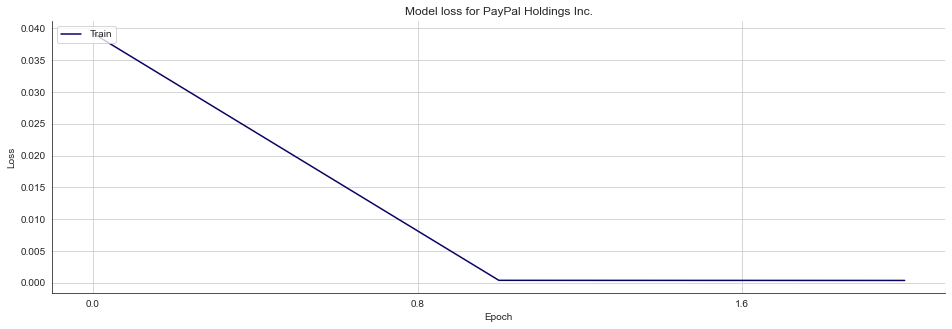

In [269]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title(f"Model loss for {stockname}")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()
fig.savefig(f"../Notebooks/Data/Cleaned_Data/Plots/{ticker}_loss.png") 


In [270]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')



metrics["ticker"].append(ticker)
metrics["Median Absolute Error (MAE)"].append(MAE)
metrics["Mean Absolute Percentage Error (MAPE)"].append(MAPE)
metrics["Median Absolute Percentage Error (MDAPE)"].append(MDAPE)
print(metrics)

15/15 [==============================] - 3s 148ms/step
Median Absolute Error (MAE): 8.55
Mean Absolute Percentage Error (MAPE): 4.71 %
Median Absolute Percentage Error (MDAPE): 3.29 %
defaultdict(<class 'list'>, {'ticker': ['FB', 'ABNB', 'ABNB_WITH_SEC', 'FANG', 'MCHP', 'MELI', 'MRO', 'MTRX', 'NFLX', 'PYPL'], 'Median Absolute Error (MAE)': [9.709372588147614, 13.586562511967676, 16.14523792341644, 3.9891240392757363, 8.156490437169229, 91.64131559930098, 0.914980026317548, 0.5949035168916751, 18.783103542608963, 8.546096558902136], 'Mean Absolute Percentage Error (MAPE)': [3.516409390761089, 9.749663162411188, 12.20712184663468, 4.00672276258559, 7.7516397752255575, 6.816832422399369, 5.498691576066705, 6.19132830936434, 4.944767428923407, 4.7127816537251634], 'Median Absolute Percentage Error (MDAPE)': [2.6409540648712784, 8.093337497279608, 6.733024413459125, 3.4054905110433173, 6.0235731726826796, 5.147646414848159, 4.917866116812251, 5.482350298979504, 2.6880200808590606, 3.2882007

In [271]:
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("../Notebooks/Data/Cleaned_Data/metrics.csv")

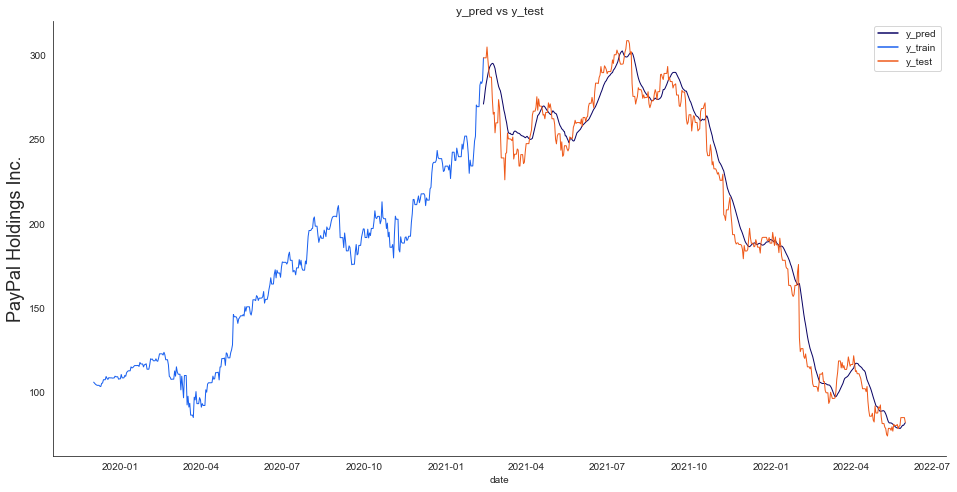

In [272]:
# The date from which on the date is displayed
display_start_date = "2019-12-01" 
stockname = f"{stockname}"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['close'][:train_data_len + 1]).rename(columns={'close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['close'][train_data_len:]).rename(columns={'close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
#df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
#ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()
fig.savefig(f"../Notebooks/Data/Cleaned_Data/Plots/{ticker}_model.png") 

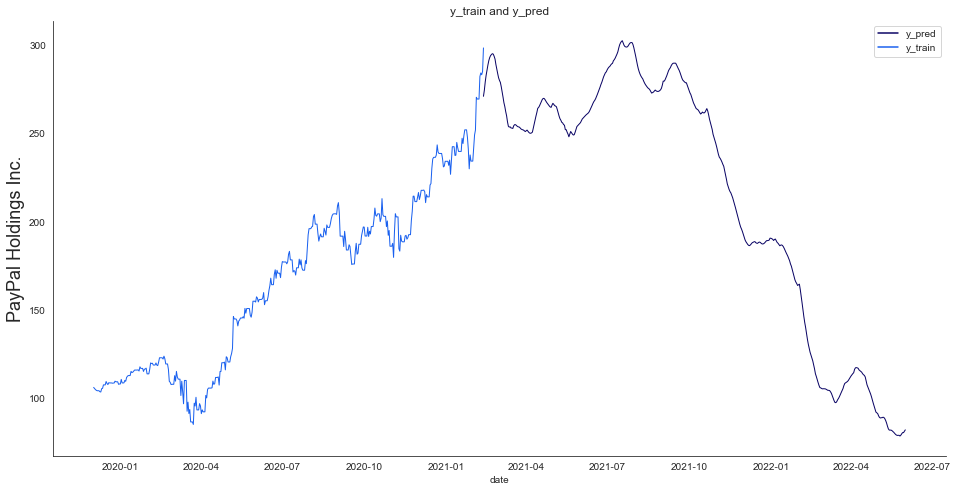

In [273]:
# Model No Test
# The date from which on the date is displayed
display_start_date = "2019-12-01" 
stockname = stockname

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['close'][:train_data_len + 1]).rename(columns={'close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['close'][train_data_len:]).rename(columns={'close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_train and y_pred")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
#df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
#ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()
fig.savefig(f"../Notebooks/Data/Cleaned_Data/Plots/{ticker}_model_no_test.png")
